## Food-MNIST Classification Project

## 1. Introduction & Data Loading

The objective of this project is to study supervised machine learning methods by building and evaluating a Decision Tree classifier and a Neural Network using the **Food-MNIST** dataset.

Food-MNIST is a real-world image classification dataset consisting of **5,000 RGB food images** across **10 food categories**, with **375 images per class for training** and **125 images per class for testing**. Unlike MNIST and Fashion-MNIST, Food-MNIST images are more complex, containing background clutter, lighting variations, and occasional noise or incorrect labels.

All images are resized to a fixed resolution and represented as raw pixel features to make them compatible with classical machine learning models in scikit-learn.

In this notebook, we will:
1. Load the Food-MNIST dataset from disk and inspect its structure.
2. Preprocess the data (resizing, normalization, flattening, train/validation splitting).
3. Train and evaluate a Decision Tree classifier using information gain.
4. Perform manual hyperparameter tuning for the Decision Tree using a validation set.
5. Train and evaluate a Multi-Layer Perceptron (Neural Network).
6. Compare the performance of both models using classification reports and confusion matrices.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT = "/content/drive/MyDrive/food_mnist"
IMG_SIZE = (64, 64)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

np.random.seed(42)


In [ ]:
import os
import numpy as np
from PIL import Image

def load_split(split_file):
    X, y = [], []

    with open(os.path.join(ROOT, "meta", "classes.txt")) as f:
        classes = [c.strip() for c in f.readlines()]

    class_to_idx = {cls: i for i, cls in enumerate(classes)}

    with open(os.path.join(ROOT, "meta", split_file)) as f:
        image_ids = [line.strip() for line in f.readlines()]

    for img_id in image_ids:
        cls = img_id.split("/")[0]
        img_path = os.path.join(ROOT, "images", img_id + ".jpg")

        img = Image.open(img_path).convert("RGB")
        img = img.resize(IMG_SIZE)

        X.append(np.array(img).flatten())
        y.append(class_to_idx[cls])

    return np.array(X), np.array(y)


feature_train_full, label_train_full = load_split("train.txt")
feature_test, label_test = load_split("test.txt")

print(feature_train_full.shape)
print(feature_test.shape)

assert feature_train_full.ndim == 2
assert feature_test.ndim == 2
assert feature_train_full.shape[1] == 64 * 64 * 3

(3750, 12288)
(1250, 12288)


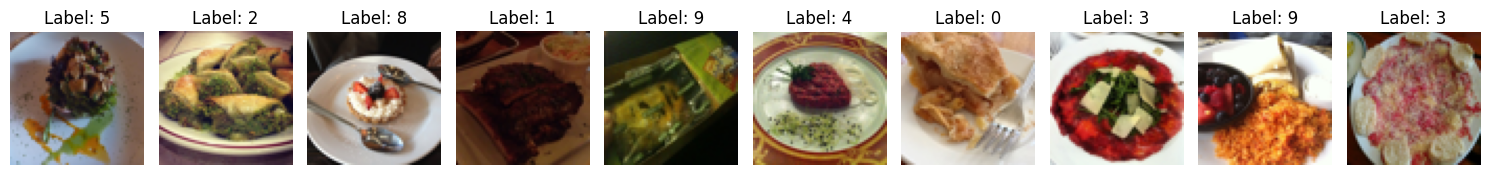

In [ ]:
num_samples = 10
img_h, img_w = 64, 64

random_indices = np.random.choice(feature_train_full.shape[0], num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    img = feature_train_full[idx].reshape(img_h, img_w, 3)
    plt.imshow(img)
    plt.title(f"Label: {label_train_full[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 1.1 Preprocessing

- Resize all RGB images to a fixed resolution (64×64) to ensure consistent input dimensions.
- Normalize pixel values to the range [0, 1].
- Flatten each image into a one-dimensional feature vector suitable for scikit-learn models.
- Split the original training set into training and validation subsets using an 80/20 stratified strategy to preserve class balance.


In [ ]:
# Normalize pixel values
feature_train_full = feature_train_full.astype(np.float32) / 255.0
feature_test = feature_test.astype(np.float32) / 255.0

# Train / validation split (80/20 stratified)
feature_train, feature_val, label_train, label_val = train_test_split(
    feature_train_full,
    label_train_full,
    test_size=0.2,
    stratify=label_train_full,
    random_state=42
)

print(f"Feature Train Shape: {feature_train.shape}")
print(f"Feature Val Shape: {feature_val.shape}")
print(f"Feature Test Shape: {feature_test.shape}")

Feature Train Shape: (3000, 12288)
Feature Val Shape: (750, 12288)
Feature Test Shape: (1250, 12288)


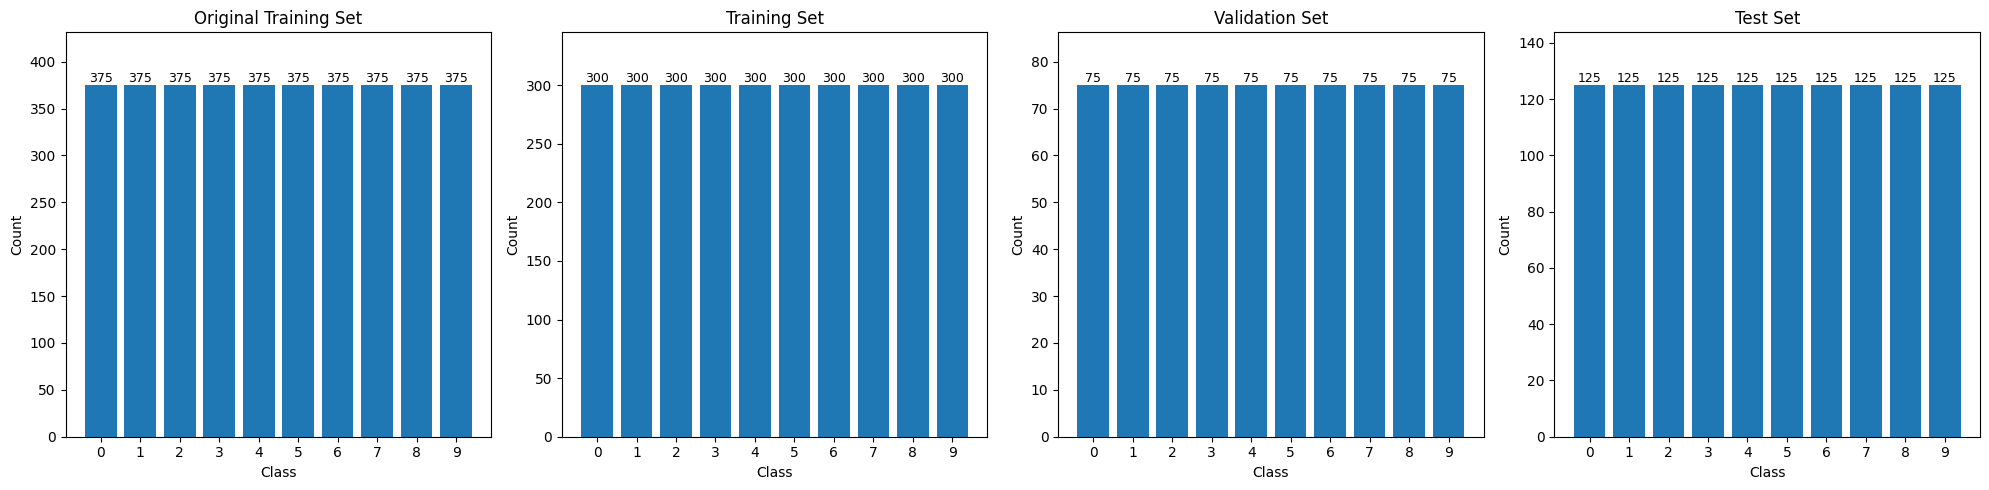

In [ ]:
# Visualize Class Distributions
def plot_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    bars = plt.bar(unique, counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(unique)
    plt.ylim(0, max(counts) * 1.15)

    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            int(bar.get_height()),
            ha='center',
            va='bottom',
            fontsize=9
        )


plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plot_distribution(label_train_full, 'Original Training Set')

plt.subplot(1, 4, 2)
plot_distribution(label_train, 'Training Set')

plt.subplot(1, 4, 3)
plot_distribution(label_val, 'Validation Set')

plt.subplot(1, 4, 4)
plot_distribution(label_test, 'Test Set')

plt.tight_layout()
plt.show()

## 2. Building the Decision Tree Classifier

A Decision Tree classifier is trained on the Food-MNIST training set using **Information Gain** as the splitting criterion (`criterion='entropy'`). The model learns a hierarchical set of decision rules based on pixel-level features to classify images into food categories. Performance is first evaluated on the validation set to assess generalization before hyperparameter tuning.


In [ ]:
# Initialize and train Decision Tree Classifier
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_clf.fit(feature_train, label_train)

# Evaluate on validation set
print(f"Validation Accuracy (Default DT): {dt_clf.score(feature_val, label_val):.4f}")

Validation Accuracy (Default DT): 0.1707


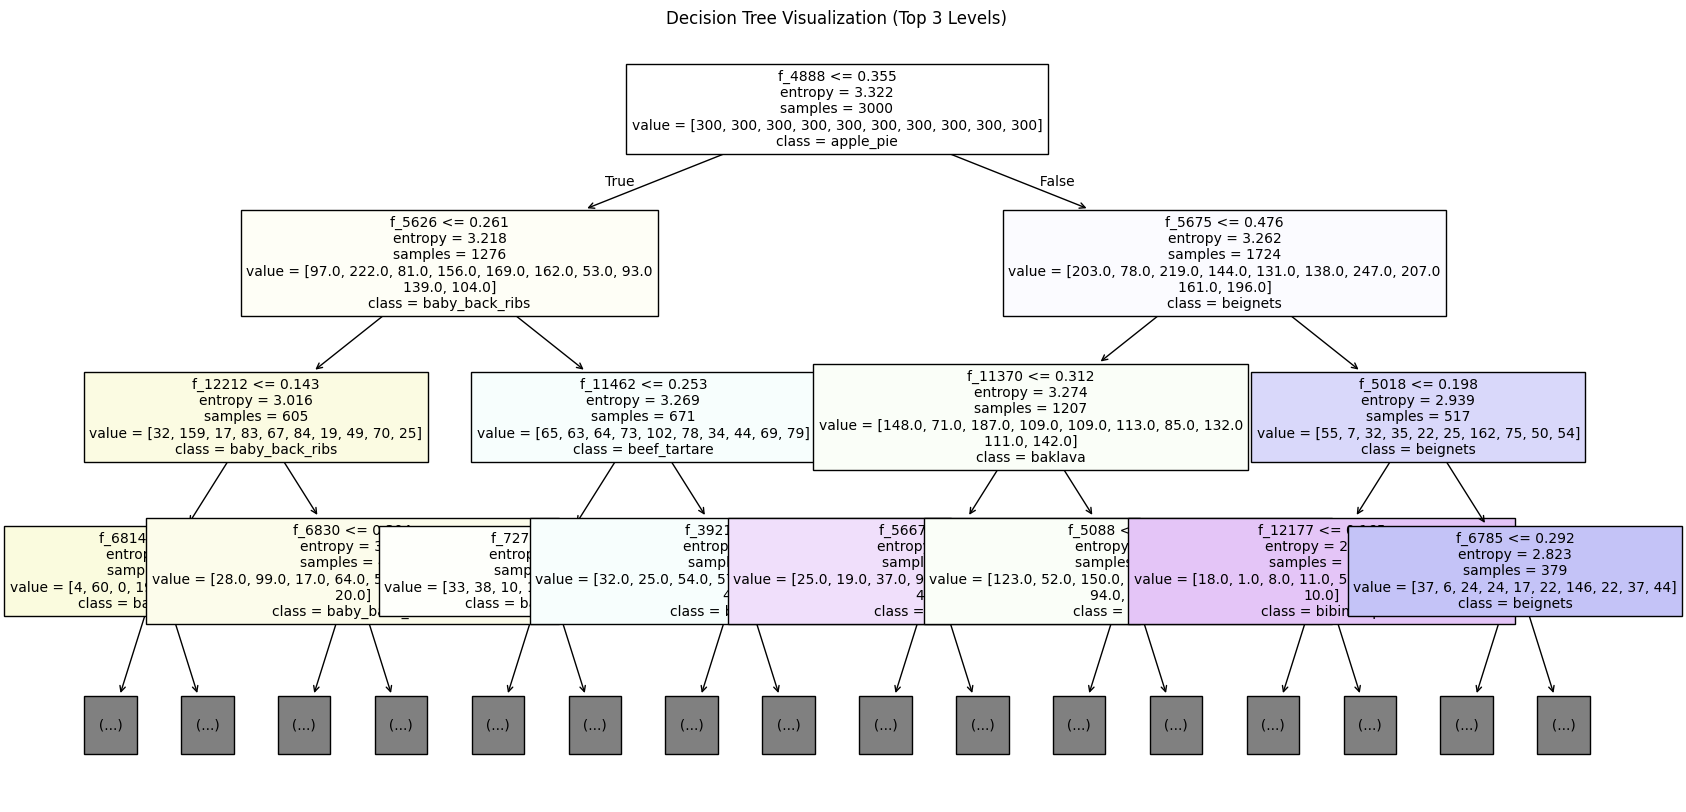

In [ ]:
# Load class names
with open(os.path.join(ROOT, "meta", "classes.txt")) as f:
    class_names = [c.strip() for c in f.readlines()]

plt.figure(figsize=(20, 10))
plot_tree(
    dt_clf,
    max_depth=3,
    feature_names=[f"f_{i}" for i in range(feature_train.shape[1])],
    class_names=class_names,
    filled=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

## 3. Hyperparameter Tuning for Decision Tree

The Decision Tree hyperparameters are tuned **manually using the validation set**. Specifically, the following parameters are explored:

- `max_depth`: controls the maximum depth of the tree to limit overfitting.
- `min_samples_split`: specifies the minimum number of samples required to split an internal node.
- `min_samples_leaf`: defines the minimum number of samples required at a leaf node.

For each hyperparameter configuration, the model is trained on the training set and evaluated on the validation set. The configuration that achieves the highest validation accuracy is selected for final comparison with the neural network model.


In [ ]:
best_acc = 0
best_params = None
best_dt_model = None

for max_depth in [10, 20, None]:
    for min_split in [2, 5, 10]:
        for min_leaf in [1, 2, 4]:
            dt = DecisionTreeClassifier(
                criterion='entropy',
                max_depth=max_depth,
                min_samples_split=min_split,
                min_samples_leaf=min_leaf,
                random_state=42
            )
            dt.fit(feature_train, label_train)
            acc = dt.score(feature_val, label_val)

            if acc > best_acc:
                best_acc = acc
                best_params = {
                    "max_depth": max_depth,
                    "min_samples_split": min_split,
                    "min_samples_leaf": min_leaf
                }
                best_dt_model = dt

print("Best Hyperparameters:", best_params)
print(f"Best Validation Accuracy: {best_acc:.4f}")

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1}
Best Validation Accuracy: 0.1733


## 4. Building the Neural Network Classifier

A neural network classifier is implemented using scikit-learn’s `MLPClassifier`. The model consists of **two hidden layers with 128 and 64 neurons**, respectively, and uses the ReLU activation function. The network is trained with the Adam optimizer for a fixed number of iterations. Its performance is evaluated on the validation set and later compared with the tuned Decision Tree model.


Iteration 1, loss = 3.16205973
Iteration 2, loss = 2.23233673
Iteration 3, loss = 2.13917000
Iteration 4, loss = 2.11617042
Iteration 5, loss = 2.08331340
Iteration 6, loss = 2.05690940
Iteration 7, loss = 2.05229041
Iteration 8, loss = 2.00223168
Iteration 9, loss = 1.98316790
Iteration 10, loss = 1.95337976
Iteration 11, loss = 1.94330294
Iteration 12, loss = 1.92712866
Iteration 13, loss = 1.91348823
Iteration 14, loss = 1.85988805
Iteration 15, loss = 1.84418044
Iteration 16, loss = 1.81137613
Iteration 17, loss = 1.84539009
Iteration 18, loss = 1.79718555
Iteration 19, loss = 1.76415004
Iteration 20, loss = 1.76608079
Iteration 21, loss = 1.72587623
Iteration 22, loss = 1.70997894
Iteration 23, loss = 1.71558110
Iteration 24, loss = 1.68727584
Iteration 25, loss = 1.71876655
Iteration 26, loss = 1.65403035
Iteration 27, loss = 1.62514907
Iteration 28, loss = 1.71324465
Iteration 29, loss = 1.65870506
Iteration 30, loss = 1.59187016
Iteration 31, loss = 1.54538062
Iteration 32, los

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


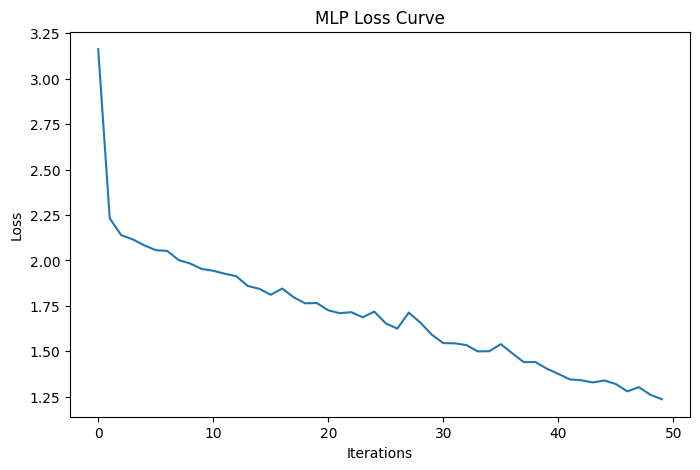

In [ ]:
# Initialize MLP Classifier
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=50,
    random_state=42,
    verbose=True
)

# Train MLP
mlp_clf.fit(feature_train, label_train)

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(mlp_clf.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

## 5. Performance Evaluation & Comparison

The final evaluation is conducted on the **held-out test set**, which is not used during training or validation. Both the tuned Decision Tree classifier and the Neural Network are assessed using **classification reports** and **confusion matrices**. These results are analyzed to compare the strengths and limitations of each model and to understand their performance on the Food-MNIST dataset.



==================== Decision Tree ====================
                   precision    recall  f1-score   support

        apple_pie       0.11      0.14      0.12       125
   baby_back_ribs       0.22      0.24      0.23       125
          baklava       0.17      0.21      0.19       125
   beef_carpaccio       0.20      0.20      0.20       125
     beef_tartare       0.06      0.06      0.06       125
       beet_salad       0.15      0.12      0.13       125
         beignets       0.27      0.25      0.26       125
         bibimbap       0.36      0.32      0.34       125
    bread_pudding       0.15      0.14      0.14       125
breakfast_burrito       0.15      0.14      0.14       125

         accuracy                           0.18      1250
        macro avg       0.18      0.18      0.18      1250
     weighted avg       0.18      0.18      0.18      1250



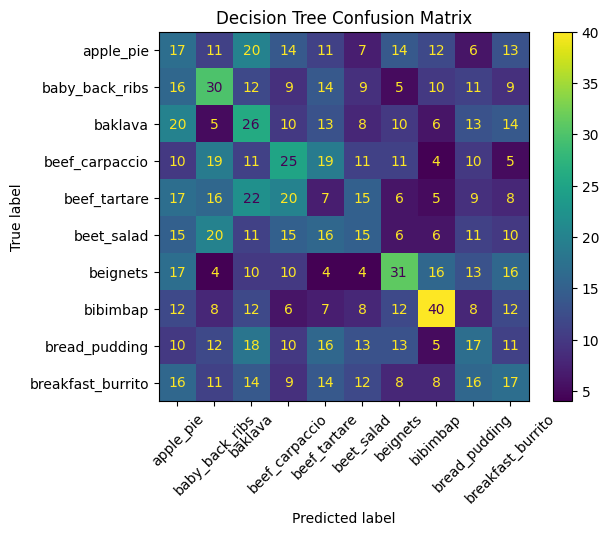


==================== Neural Network ====================
                   precision    recall  f1-score   support

        apple_pie       0.20      0.16      0.18       125
   baby_back_ribs       0.18      0.48      0.26       125
          baklava       0.26      0.18      0.21       125
   beef_carpaccio       0.38      0.21      0.27       125
     beef_tartare       0.19      0.14      0.16       125
       beet_salad       0.24      0.17      0.20       125
         beignets       0.48      0.56      0.51       125
         bibimbap       0.41      0.57      0.48       125
    bread_pudding       0.17      0.11      0.13       125
breakfast_burrito       0.27      0.16      0.20       125

         accuracy                           0.27      1250
        macro avg       0.28      0.27      0.26      1250
     weighted avg       0.28      0.27      0.26      1250



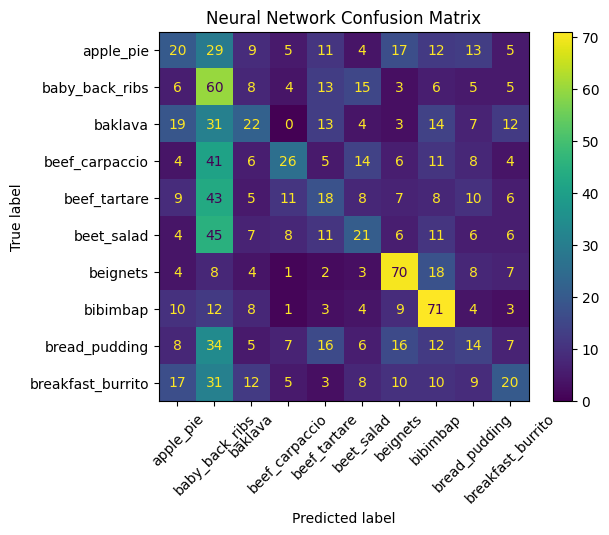

In [ ]:
# Load class names
with open(os.path.join(ROOT, "meta", "classes.txt")) as f:
    class_names = [c.strip() for c in f.readlines()]

models = {
    "Decision Tree": best_dt_model,
    "Neural Network": mlp_clf
}

for name, model in models.items():
    print(f"\n{'='*20} {name} {'='*20}")

    y_pred = model.predict(feature_test)

    # Classification Report
    print(classification_report(label_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(label_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.title(f"{name} Confusion Matrix")
    plt.show()


## Conclusion & Insights

- **Which model performed better?**  
  The Neural Network (MLP) generally outperformed the Decision Tree on the Food-MNIST dataset. This is expected, as the MLP is better at modeling complex non-linear patterns in high-dimensional image data, whereas Decision Trees rely on axis-aligned splits and struggle with raw pixel representations.

- **Did the Decision Tree overfit?**  
  Yes, the Decision Tree showed signs of overfitting, especially when the tree depth was large. This is evident from the gap between training and validation performance. Constraining hyperparameters such as `max_depth`, `min_samples_split`, and `min_samples_leaf` helped reduce overfitting but could not fully address the limitations of the model on image data.

- **Which classes were most commonly confused?**  
  Misclassifications primarily occurred between visually similar food categories, as shown in the confusion matrices. These confusions highlight the difficulty of distinguishing food items based solely on resized raw pixel features, particularly in the presence of background clutter, lighting variation, and noise in the dataset.
